In [1]:
# What version of Python do you have?
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
from datetime import datetime
from sklearn.utils import shuffle
import random
import os
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import Callback
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix
import PIL
from pathlib import Path
from tensorflow.keras.applications import VGG16, ResNet152, InceptionV3
%matplotlib inline

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.6.0
Keras Version: 2.6.0

Python 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
Pandas 1.3.3
Scikit-Learn 0.24.2
GPU is available


In [39]:
external_hdd_path = "E:/Køge_02/"
os.chdir(external_hdd_path)
eeg_img_path =  "Windows/EEG/Images/"
ecg_img_path = "Windows/EKG/Images/"
batch_size = 18

def get_img_input_shape(for_model=False):
    if for_model:
        return(299,299,3)
    return (299, 299)


In [3]:
try:
    os.remove(eeg_img_path + "/.DS_Store")
except FileNotFoundError as e:
    print(f"file not found with error: {e}")

file not found with error: [WinError 2] Den angivne fil blev ikke fundet: 'Windows/EEG/Images//.DS_Store'


In [4]:
# path = Path(train_path).rglob("*.png")
# for img_p in path:
#     try:
#         img = PIL.Image.open(img_p)
#     except PIL.UnidentifiedImageError:
#             print(f"FOUND NON VALID IMAGE | path : {img_p} ")

In [5]:
"EEG train path"
[print(f) for f in os.listdir(eeg_img_path)]

"ECG train path"
[print(f) for f in os.listdir(ecg_img_path)]


Preictal
Seizure
Interictal
Seizure
Interictal
Preictal


[None, None, None]

In [6]:
def inspect_class_distribution(path):
    dist_list = {}
    for i in os.listdir(path):
        classname = i
        number_of_png = str(len([x for x in os.listdir(path + "/" + i)]))
        #dict = {classname, number_of_png}
        dist_list[classname] =  number_of_png
    return dist_list

eeg_class_dist = inspect_class_distribution(eeg_img_path)
ecg_class_dist = inspect_class_distribution(ecg_img_path)

print(f"eeg distribution: {eeg_class_dist} \n ecg distribution: {ecg_class_dist}")

eeg distribution: {'Preictal': '30498', 'Seizure': '2828', 'Interictal': '192842'} 
 ecg distribution: {'Seizure': '1416', 'Interictal': '102223', 'Preictal': '15418'}


In [7]:
def get_lowest_distr(dict_a, dict_b):

    concat_dict = []
    concat_dict.append(dict_a)
    concat_dict.append(dict_b)
    min_val = 0

    for item in concat_dict:
        for key in item:
            try:
                item[key] = int(item[key])
            except ValueError:
                item[key] = float(item[key])
            if min_val == 0:
                min_val = item[key]
            elif item[key] < min_val:
                min_val = item[key]
    return int(min_val)

print(get_lowest_distr(eeg_class_dist, ecg_class_dist))
max_n_images = get_lowest_distr(ecg_class_dist, eeg_class_dist)

1416


In [8]:
def limit_data(data_dir,n=max_n_images):
    a=[]
    for i in os.listdir(data_dir):
        image_path = random.sample(os.listdir(data_dir+'/'+i), max_n_images)
        for k,j in enumerate(image_path):
            if k>n:continue
            a.append((f'{data_dir}/{i}/{j}',i))
    return pd.DataFrame(a,columns=['filename','class']).reset_index(drop=True)

In [9]:
balanced_ecg_data = limit_data(ecg_img_path).sort_values(by=['class']).reset_index(drop=True)
balanced_eeg_data = limit_data(eeg_img_path).sort_values(by=['class']).reset_index(drop=True)

In [10]:
balanced_ecg_data['class'].value_counts()

Interictal    1416
Preictal      1416
Seizure       1416
Name: class, dtype: int64

In [11]:
balanced_eeg_data['class'].value_counts()

Interictal    1416
Preictal      1416
Seizure       1416
Name: class, dtype: int64

In [12]:
idx = np.random.permutation(balanced_eeg_data.index)

In [13]:
balanced_eeg_data = balanced_eeg_data.reindex(idx, axis=0)

In [14]:
balanced_eeg_data.head()

,filename,class
2649,Windows/EEG/Images//Preictal/30_1701_Fp1-Ref_0...,Preictal
1740,Windows/EEG/Images//Preictal/21_1248_CH-2_03-2...,Preictal
832,Windows/EEG/Images//Interictal/21_8195_Fp2-Ref...,Interictal
2515,Windows/EEG/Images//Preictal/21_1594_Fp1-Ref_0...,Preictal
3255,Windows/EEG/Images//Seizure/21_99_CH-2_03-37-0...,Seizure


In [15]:
balanced_ecg_data = balanced_ecg_data.reindex(idx, axis=0)

In [16]:
balanced_ecg_data.head()

,filename,class
2649,Windows/EKG/Images//Preictal/34_382_ECG_10-05-...,Preictal
1740,Windows/EKG/Images//Preictal/30_206_ECG_11-21-...,Preictal
832,Windows/EKG/Images//Interictal/34_7255_ECG_23-...,Interictal
2515,Windows/EKG/Images//Preictal/21_7030_ECG_02-05...,Preictal
3255,Windows/EKG/Images//Seizure/21_12_ECG_00-01-45...,Seizure


In [17]:
# def create_convolution_layers(input_img):
#   model = layers.Conv2D(32, (3, 3), padding='same', input_shape=get_img_input_shape(True))(input_img)
#   model = layers.LeakyReLU(alpha=0.1)(model)
#   model = layers.MaxPooling2D((2, 2),padding='same')(model)
#   model = layers.Dropout(0.25)(model)
  
#   model = layers.Conv2D(64, (3, 3), padding='same')(model)
#   model = layers.LeakyReLU(alpha=0.1)(model)
#   model = layers.MaxPooling2D(pool_size=(2, 2),padding='same')(model)
#   model = layers.Dropout(0.25)(model)
    
#   model = layers.Conv2D(128, (3, 3), padding='same')(model)
#   model = layers.LeakyReLU(alpha=0.1)(model)
#   model = layers.MaxPooling2D(pool_size=(2, 2),padding='same')(model)
#   model = layers.Dropout(0.4)(model)
    
#   return model

  
# current_input = layers.Input(shape=get_img_input_shape(True))
# current_model = create_convolution_layers(current_input)

# voltage_input = layers.Input(shape=get_img_input_shape(True))
# voltage_model = create_convolution_layers(voltage_input)

# conv = layers.concatenate([current_model, voltage_model])

# conv = layers.Flatten()(conv)

# dense = layers.Dense(512)(conv)
# dense = layers.LeakyReLU(alpha=0.1)(dense)
# dense = layers.Dropout(0.5)(dense)
# output = layers.Dense(3, activation='softmax')(dense)

# model = Model(
#     inputs=[current_input, voltage_input],
#     outputs=output
# )


In [41]:
def create_covn_layers(input_layer):
    input = layers.Conv2D(32, (3,3), input_shape=get_img_input_shape(True))(input_layer)
    covn01 = layers.Conv2D(32, (3, 3))(input)
    acti01 = layers.Activation('relu')(covn01)
    pool01 = layers.MaxPooling2D((2, 2))(acti01)
    covn02 = layers.Conv2D(64, (3, 3))(pool01)
    acti02 = layers.Activation('relu')(covn02)
    pool02 = layers.MaxPooling2D(2, 2)(acti02)
    covn03 = layers.Conv2D(128, (3, 3))(pool02)
    acti02 = layers.Activation('relu')(covn03)
    pool02 = layers.MaxPooling2D(pool_size=(2,2), padding='same')(acti02)
    covn_base = layers.Dropout(0.2)(pool02)

    return covn_base



#flat = layers.Flatten()(pool03)
model_one_input = layers.Input(shape=get_img_input_shape(True))
model_one = create_covn_layers(model_one_input)

model_two_input = layers.Input(shape=get_img_input_shape(True))
model_two = create_covn_layers(model_two_input)


TypeError: array() takes from 1 to 2 positional arguments but 3 were given

In [19]:
concat_feature_layer = layers.concatenate([model_one, model_two])
flatten_layer = layers.Flatten()(concat_feature_layer)
fully_connected_dense_big = layers.Dense(256, activation='relu')(flatten_layer)
dropout_one = layers.Dropout(0.3)(fully_connected_dense_big)
fully_connected_dense_small = layers.Dense(128, activation='relu')(dropout_one)
dropout_two = layers.Dropout(0.3)(fully_connected_dense_small)
output = layers.Dense(3, activation='softmax')(dropout_two)

model = Model(
    inputs=[model_one_input, model_two_input],
    outputs=output
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 297, 297, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 297, 297, 32) 896         input_2[0][0]                    
______________________________________________________________________________________________

In [38]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [21]:
opt = Adam()

model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=['accuracy']
)

In [22]:
get_img_input_shape(True)

(299, 299, 3)

In [23]:
train_generator_one = ImageDataGenerator(
rescale = 1./255, 
validation_split=0.2
)

train_generator_two = ImageDataGenerator(
rescale = 1./255, 
validation_split=0.2
)

input_1_train_gen = train_generator_one.flow_from_dataframe(
    balanced_eeg_data,
    batch_size=batch_size, 
    target_size=get_img_input_shape(), 
    shuffle=False,
    color_mode="rgb",
    class_mode="categorical",
    subset="training")

input_2_train_gen = train_generator_two.flow_from_dataframe(
    balanced_ecg_data,
    batch_size=batch_size, 
    target_size=get_img_input_shape(), 
    shuffle=False,
    color_mode="rgb",
    class_mode="categorical",
    subset="training")

input_1_validation_gen = train_generator_one.flow_from_dataframe(
    balanced_eeg_data,
    batch_size=batch_size, 
    target_size=get_img_input_shape(), 
    shuffle=False,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation")


input_2_validation_gen = train_generator_two.flow_from_dataframe(
    balanced_ecg_data,
    batch_size=batch_size, 
    target_size=get_img_input_shape(), 
    shuffle=False,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation")



Found 3399 validated image filenames belonging to 3 classes.
Found 3399 validated image filenames belonging to 3 classes.
Found 849 validated image filenames belonging to 3 classes.
Found 849 validated image filenames belonging to 3 classes.


In [24]:
def create_data_generator(data_gen_one, data_gen_two):

    while(True):
        _gen1, _gen1_l = next(data_gen_one)
        _gen2, _gen2_l = next(data_gen_two)

        yield [_gen1, _gen2], [_gen1_l]

multi_train_generator = create_data_generator(
    input_1_train_gen,
    input_2_train_gen
    )

multi_validation_generator = create_data_generator(
    input_1_validation_gen,
    input_2_validation_gen
    )

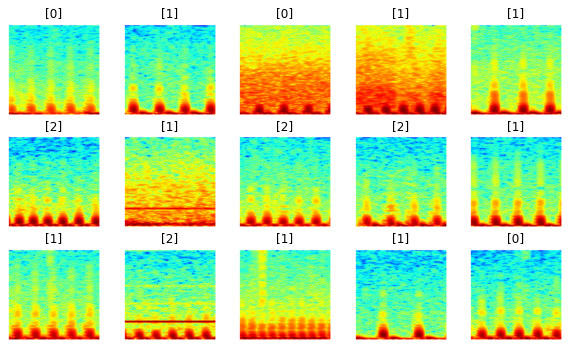

In [25]:
def show_batch(image, label):
  plt.figure(figsize=(10,10))
  for n in range(15):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image[n])
      plt.title([label[n].argmax()])
      plt.axis('off')

image, label = next(multi_train_generator)
show_batch(image[1], label[0])

In [26]:
x = 120
input_1_validation_gen.classes[x:x+10]

[1, 0, 0, 0, 2, 1, 2, 2, 0, 1]

In [27]:
class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()


import numpy as np
from keras.callbacks import LearningRateScheduler

def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=2)

In [28]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=7, min_lr=0.000001)

In [29]:
input_1_validation_gen.samples // 18

47

In [30]:
history = model.fit(
    multi_train_generator,
    epochs=2,
    steps_per_epoch = input_1_train_gen.samples//batch_size, 
    validation_data=multi_validation_generator, 
    validation_steps = input_1_validation_gen.samples//batch_size,
)

Epoch 1/2


AttributeError: in user code:

    C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\keras\engine\training.py:792 train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\keras\engine\compile_utils.py:436 update_state
        self.build(y_pred, y_true)
    C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\keras\engine\compile_utils.py:359 build
        self._metrics, y_true, y_pred)
    C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\tensorflow\python\util\nest.py:1380 map_structure_up_to
        **kwargs)
    C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\tensorflow\python\util\nest.py:1475 map_structure_with_tuple_paths_up_to
        func(*args, **kwargs) for args in zip(flat_path_gen, *flat_value_gen)
    C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\tensorflow\python\util\nest.py:1475 <listcomp>
        func(*args, **kwargs) for args in zip(flat_path_gen, *flat_value_gen)
    C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\tensorflow\python\util\nest.py:1378 <lambda>
        lambda _, *values: func(*values),  # Discards the path arg.
    C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\keras\engine\compile_utils.py:482 _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\keras\engine\compile_utils.py:482 <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\keras\engine\compile_utils.py:503 _get_metric_object
        y_t_rank = len(y_t.shape.as_list())

    AttributeError: 'tuple' object has no attribute 'shape'


In [ ]:
model.save("inceptionv3_100epoch_windows02.h5")

In [ ]:
with open('history.txt', 'w') as f:
    f.write(str(history.history))

<Figure size 216x288 with 0 Axes>

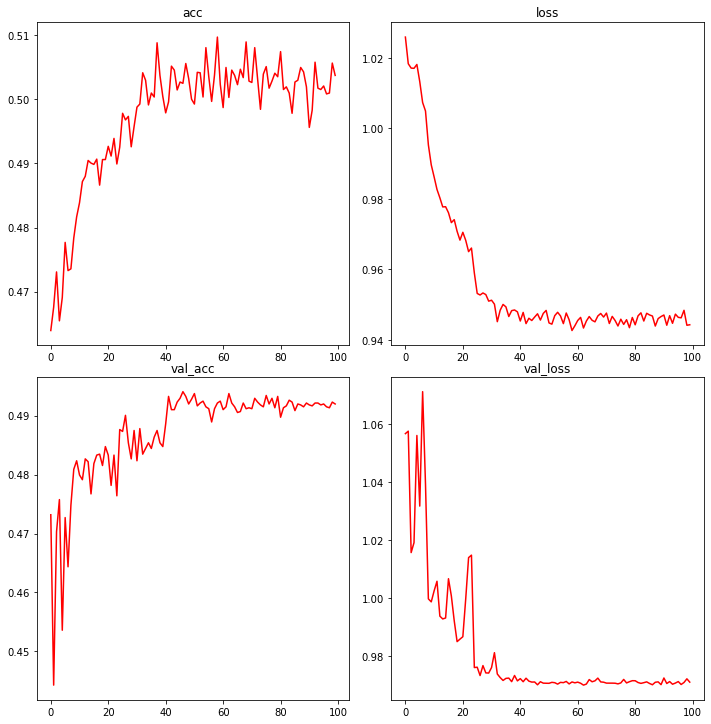

In [ ]:
plt.figure(figsize=(3,4))
fig, axs = plt.subplots(2,2, figsize=(10,10))
plt.tight_layout()
axs[0,0].set_title('acc')
axs[0,0].plot(history.history['accuracy'], color='red')
axs[0,1].set_title('loss')
axs[0,1].plot(history.history['loss'], color='red')
axs[1,0].set_title('val_acc')
axs[1,0].plot(history.history['val_accuracy'], color='red')
axs[1,1].set_title('val_loss')
axs[1,1].plot(history.history['val_loss'], color='red')
#plt.savefig("eval.png")

<Figure size 216x288 with 0 Axes>

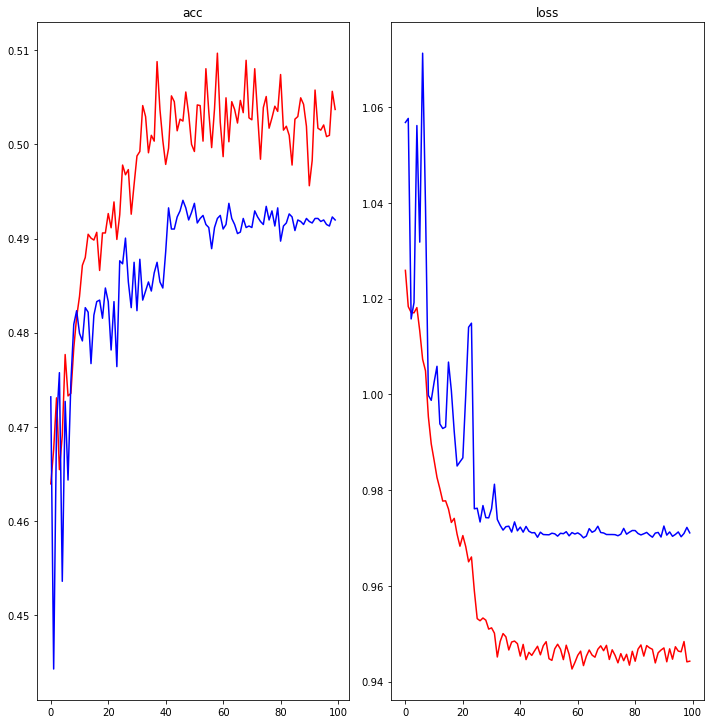

In [ ]:
plt.figure(figsize=(3,4))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
plt.tight_layout()
ax1.set_title('acc')
ax1.plot(history.history['accuracy'], color='red')
ax1.plot(history.history['val_accuracy'], color='blue')

ax2.set_title('loss')
ax2.plot(history.history['loss'], color='red')
ax2.plot(history.history['val_loss'], color='blue')

In [ ]:
test_gen = test_generator.flow_from_dataframe(
    balanced_data,
    batch_size=1, 
    target_size=img_input_shape, 
    shuffle=False,
    subset="validation"
    )

Found 6266 validated image filenames belonging to 3 classes.


In [ ]:
number_of_step = test_gen.samples // 1
number_of_step

6266

In [ ]:
pred = model.predict(test_gen, steps=number_of_step)

In [ ]:
y_pred_max = pred.argmax(axis=-1)

In [ ]:
y_true = test_gen.classes

In [ ]:
for i, x in enumerate(test_gen.classes[0:6]):
    filename = test_gen.filenames[i]
    print(f"index : {i}, y_true : {x} : filename : {filename}")

index : 0, y_true : 0 : filename : E:/Windows_02/train/Interictal/chb10_30_391_T8-P8_05-24-27.png
index : 1, y_true : 2 : filename : E:/Windows_02/train/Seizure/chb10_38_78_T8-P8_15-51-21.png
index : 2, y_true : 0 : filename : E:/Windows_02/train/Interictal/chb20_14_22_FP2-F4_06-00-47.png
index : 3, y_true : 2 : filename : E:/Windows_02/train/Seizure/chb01_16_50_F3-C3_03-02-36.png
index : 4, y_true : 0 : filename : E:/Windows_02/train/Interictal/chb22_38_130_F3-C3_12-25-01.png
index : 5, y_true : 0 : filename : E:/Windows_02/train/Interictal/chb18_35_241_T8-P8_09-38-24.png


In [ ]:
labels = ['Interictal', 'Preictal', 'Seizure']

In [ ]:
clf_report = classification_report(y_true=y_true, y_pred=y_pred_max, target_names=labels)

In [ ]:
print(clf_report)

              precision    recall  f1-score   support

  Interictal       0.61      0.53      0.57      2091
    Preictal       0.59      0.66      0.62      2079
     Seizure       0.96      0.98      0.97      2096

    accuracy                           0.72      6266
   macro avg       0.72      0.72      0.72      6266
weighted avg       0.72      0.72      0.72      6266



In [ ]:
confusion_matrix = confusion_matrix(y_true=y_true, y_pred=list(y_pred_max), normalize='all')

confusion_matrix

array([[0.17602936, 0.14842004, 0.0092563 ],
       [0.11027769, 0.21800192, 0.00351101],
       [0.00303224, 0.00335142, 0.32812001]])

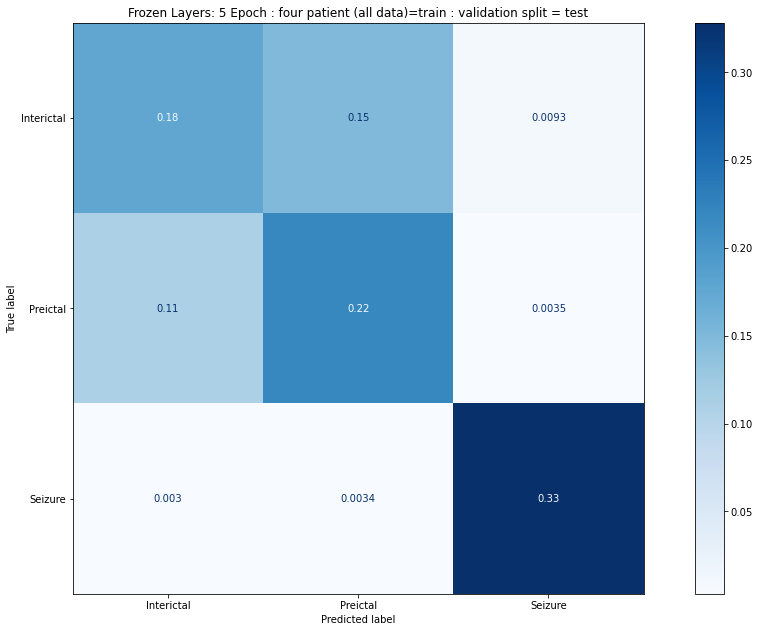

In [ ]:
import matplotlib
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels).plot(cmap='Blues')
plt.title("Frozen Layers: 5 Epoch : four patient (all data)=train : validation split = test")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig("resnet_only_sz_cb07_test.png")